<a href="https://colab.research.google.com/github/GabColombo/reinforcement/blob/master/tf_agent_DQN_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalando as bibliotecas necessárias

In [0]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install tf-agents

try:
  %tensorflow_version 2.x
except:
  pass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (599 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires

## Importando os módulos

In [0]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.policies.policy_saver import PolicySaver

tf.compat.v1.enable_v2_behavior()

#Configurar um display virtual para renderizar os ambientes Gym

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
tf.version.VERSION

'2.1.0'

## Hyperparâmetros

In [0]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 100000 # @param {type:"integer"}

batch_size = 64 # @param {type:"integer"}
learning_rate = 1e-3 # @param {type:"number"}
log_interval = 200 # @param {type:"integer"}

num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

## Ambiente

In [0]:
env_name = 'CartPole-v0' # @param{type:"string"}

env = suite_gym.load(env_name)

### Informações sobre o ambiente

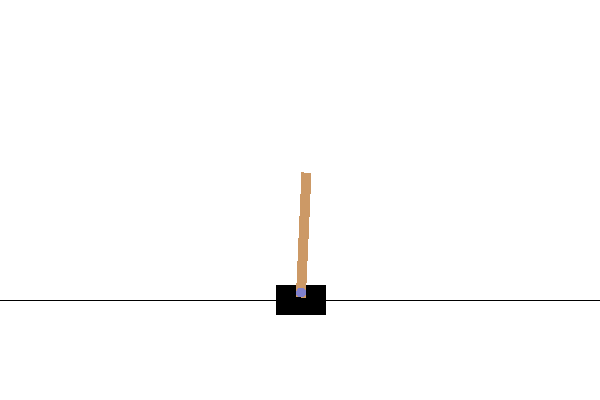

In [0]:
env.reset()
PIL.Image.fromarray(env.render())

In [0]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [0]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [0]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


### Realizando uma ação no ambiente

In [0]:
time_step = env.reset()
print('Time Step: ')
print(time_step)

action = 1

next_time_step = env.step(action)
print('Next time step: ')
print(next_time_step)

Time Step: 
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.01895351, -0.01515035,  0.04441069, -0.04895841], dtype=float32))
Next time step: 
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.0186505 ,  0.17930758,  0.04343152, -0.32730526], dtype=float32))


### Criando um ambiente de treino e um ambiente de teste

In [0]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agente

### Criando a QNetwork

In [0]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params = fc_layer_params)

### Criando o agente

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network = q_net,
    optimizer = optimizer,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = train_step_counter)

agent.initialize()

## Política

### Criando a política de avaliação e a política para coleta de dados

In [0]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

### Criando uma política aleatória e executando uma ação em um ambiente de exemplo

In [0]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))

time_step = example_environment.reset()

random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

## Métricas e avaliação

In [0]:
# @test {"skip": true}

def compute_avg_return(environment, policy, num_episodes = 10):

  total_return = 0.0

  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

### Rodando a métrica acima em uma política aleatória, é possível ver o desempenho inicial de um agente

In [0]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

17.3

## Replay Buffer

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

In [0]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [0]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Coletar dados

### Executar alguns passos da política aleatória no ambiente e salvar no replay buffer

In [0]:
# @test{"skip": true}

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Adicionar a trajetória no replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps = 100)

#Agora o replay buffer está cheio de trajetórias

### Observar uma das trajetórias

In [0]:
#iter(replay_buffer.as_dataset()).next()

(Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.01593863, -0.03137911, -0.10254499, -0.15399222], dtype=float32)>, action=<tf.Tensor: shape=(), dtype=int64, numpy=1>, policy_info=(), next_step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>),
 BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=34>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>))

## Enviar 2 linhas do replay buffer para o agente (observação atual e próxima)

In [0]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls = 3,
    sample_batch_size = batch_size,
    num_steps = 2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [0]:
iterator = iter(dataset)

print(iterator)

### Observar os dados que estão sendo passados para o agente pelo iterador

In [0]:
#iterator.next()

(Trajectory(step_type=<tf.Tensor: shape=(64, 2), dtype=int32, numpy=
array([[1, 1],
       [1, 1],
       [1, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 0],
       [1, 1],
       [1, 1],
       [0, 1],
       [2, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 0],
       [1, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 2],
       [1, 1],
       [1, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
 

## Treinando o agente

In [0]:
# @test {"skip": true}
try:
  %%time
except:
  pass

agent.train = common.function(agent.train)

# Resetar o passo de treinamento
agent.train_step_counter.assign(0)

# Avaliar a política do agente uma vez antes do treinamento
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
  
  # Coletar alguns passos utilizando a collect_policy e armazenar no replay buffer
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)
  
  # Sortear alguns dados do buffer e atualizar a rede neural do agente
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  # Mostra o cálculo de loss a cada x passos
  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  # Calcula, mostra e armazena o retorno médio a cada x passos
  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)
  

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs
step = 200: loss = 9.83255386352539
step = 400: loss = 19.306854248046875
step = 600: loss = 32.17002868652344
step = 800: loss = 20.706138610839844
step = 1000: loss = 45.54364776611328
step = 1000: Average Return = 32.400001525878906
step = 1200: loss = 43.47307586669922
step = 1400: loss = 94.03501892089844
step = 1600: loss = 83.90321350097656
step = 1800: loss = 65.61634063720703
step = 2000: loss = 26.283414840698242
step = 2000: Average Return = 40.5
step = 2200: loss = 65.80423736572266
step = 2400: loss = 61.624603271484375
step = 2600: loss = 58.05156707763672
step = 2800: loss = 30.068763732910156
step = 3000: loss = 59.01948165893555
step = 3000: Average Return = 84.5999984741211
step = 3200: loss = 31.670650482177734
step = 3400: loss = 78.6439208984375
step = 3600: loss = 43.35778045654297
step = 3800: loss = 142.87535095214844
step = 4000: loss = 3.5113415718078613
step = 4000: Average Return = 144.699996

## Visualização

### Plotar

(6.590000200271605, 250)

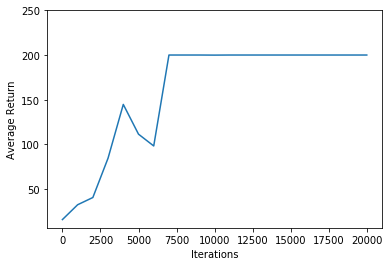

In [0]:
# @test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top = 250)

### Vídeo

### Função para criar vídeos no colab

In [0]:
def embed_mp4(filename):
  """Mostra um arquivo mp4 no notebook"""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''<video width = "640" height = "480" controls>
            <source src = "data:video/mp4;base64,{0}" type = "video/mp4">
            Your browser does not support the video tag.
        </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)s

### Iterar alguns episódios do ambiente com o agente treinado e juntar as imagens para formar o vídeo

In [0]:
def create_policy_eval_video(policy, filename, num_episodes = 5, fps = 30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained_agent")

### Visualizar um vídeo do agente com uma política aleatória para comparação

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
create_policy_eval_video(random_policy, "random_agent")

## Salvar a política após o treinamento

In [0]:
 saved_policy_path = '/content/drive/My Drive/'
 PolicySaver(eval_policy).save(saved_policy_path + 'cartpole_policy')

INFO:tensorflow:Assets written to: /content/drive/My Drive/cartpole_policy/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/cartpole_policy/assets


## Carregar a política treinada

In [0]:
policy = tf.saved_model.load(saved_policy_path + 'cartpole_policy')
policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb6f6f51c18>

## Visualizar em vídeo o agente seguindo política carregada

In [0]:
create_policy_eval_video(policy, "loaded_policy")